In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
labels = open('../TreeBERT/pretrain_data_code/java_custom_label/bert_output.json', 'r').readlines()

smells = []

for i in labels:
    test_line = json.loads(i)
    smells.append(test_line["smellKey"])

label_series = pd.Series(smells)

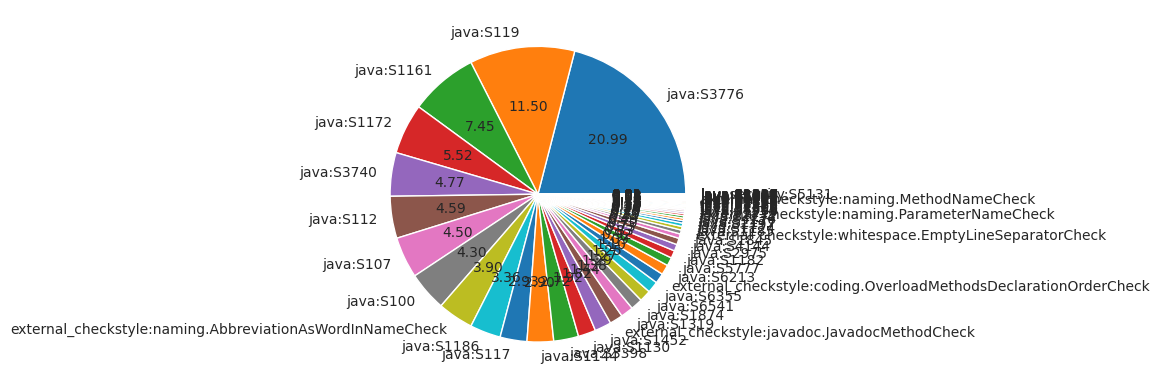

In [3]:
plt.pie(label_series.value_counts(), labels=label_series.value_counts().where(lambda x:x>15).index, autopct=lambda x:"{:.2f}".format(x));

In [4]:
from dataset import BPE, TokenVocab, TreeBERTDataset
from torch.utils.data import DataLoader

vocab = TokenVocab.load_vocab("../TreeBERT/data/vocab.large")
labeled_dataset = TreeBERTDataset(vocab, "../TreeBERT/pretrain_data_AST_tmp/java_custom_label/bert_output.json_ast", path_num=100, node_num=20,
                                    code_len=200, is_fine_tune=False, corpus_lines=None)

batch_size = 32

labeled_data_loader = DataLoader(labeled_dataset, batch_size=batch_size)

In [5]:
device = torch.device("cuda:0")
model = torch.load('../TreeBERT/data/output_rerun_rerun_extended.ep49')
model = model.to(device)
model.eval();

In [6]:
import tqdm
data_iter = tqdm.tqdm(enumerate(labeled_data_loader),
                              total=len(labeled_data_loader))

code_data_list = []

for i, data in data_iter:
    item = {key: value.to(device) for key, value in data.items()}

    with torch.no_grad():
        code_data_list.append(model(item["encoder_input"], item["node_pos_em_coeff"], item["decoder_input"]))

100%|██████████| 250/250 [01:07<00:00,  3.69it/s]


In [8]:
less_than_10 = label_series.value_counts().where(lambda x:x <= 40).dropna().index
to_drop = label_series[label_series.apply(lambda x:x in less_than_10)].index.to_numpy()

In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

ohe = OneHotEncoder(sparse_output=False)
le = LabelEncoder()

label_numpy = ohe.fit_transform(label_series.to_numpy().reshape(-1, 1))
le.fit_transform(label_series.to_numpy())
label_count = len(ohe.categories_[0])

In [11]:
from sklearn.model_selection import KFold

k_split = KFold(n_splits=5, shuffle=True)

# mask = np.ones(len(label_series), dtype=bool)
# mask[to_drop] = False

cpu_tensors = [i.cpu() for i in code_data_list]
# flattened = [torch.flatten(i, start_dim=1) for i in cpu_tensors]
before_drop = np.vstack(cpu_tensors)
# final_data = before_drop[mask, ...]
final_data = before_drop

# final_labels = label_numpy[mask, ...]
final_labels = label_numpy

In [13]:
final_data.tofile(open("dump.txt", "w"))

In [14]:
final_data.shape

(7974, 202, 1024)

In [ ]:
# k_iterator = k_split.split(final_data, final_labels)
# 
# total_score = 0 
# 
# from threading import Thread
# 
# 
# def thread_func(train_index_, test_index_, results_, i_):
#     rf_classifier = RandomForestClassifier(verbose=2)
#     rf_classifier.fit(final_data[train_index_], final_labels[train_index_])
#     score = rf_classifier.score(final_data[test_index_], final_labels[test_index_])
#     results_[i_] = score
# 
# thread_list = [None] * 5
# results = [None] * 5
# 
# for i, (train_index, test_index) in enumerate(k_iterator):
#     thread = Thread(target=thread_func, args=(train_index, test_index, results, i))
#     thread_list[i] = thread
#     thread.start()
# 
# for thread in thread_list:
#     thread.join()
# 
# print("Total average:", np.sum(results) / 5)

In [61]:
import xgboost as  xgb
from sklearn.model_selection import train_test_split


encoded_labels = le.fit_transform(ohe.inverse_transform(final_labels).ravel())

x_train, x_test, y_train, y_test = train_test_split(final_data, encoded_labels, test_size=0.33, stratify=encoded_labels)
xrf_classifier = xgb.XGBClassifier(verbosity=2, n_estimators=10)

xrf_classifier.fit(x_train, y_train);
# xrf_classifier.score(xt, yt)

[11:54:06] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[11:54:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[11:54:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[11:54:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[11:54:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[11:54:45] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[11:54:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[11:55:01] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[11:55:09] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 76 extra nodes, 0 pruned nodes, max_

In [3]:
xrf_classifier.score(x_test, y_test)

NameError: name 'xrf_classifier' is not defined